# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

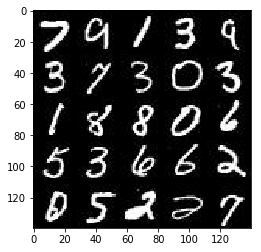

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

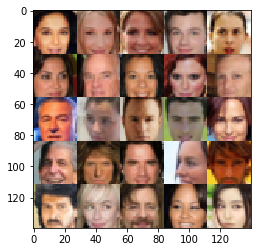

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name='input_real')
    input_z= tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.1 * layer1, layer1)
        relu1 = tf.nn.dropout(relu1, 0.7)
        # 14x14x32
        
        layer2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(0.1 * layer2, layer2)
        relu2 = tf.nn.dropout(relu2, 0.7)
        # 7x7x64
        
        layer3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(0.1 * layer3, layer3)
        relu3 = tf.nn.dropout(relu3, 0.7)
        # 4x4x128

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(0.1 * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, 0.8)
        # 7x7x512 now
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same', \
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(0.1 * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, 0.8)
        # 14x14x256 now
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=1, padding='same', \
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(0.1 * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, 0.8)
        # 14x14x128 now
        
        layer4 = tf.layers.conv2d_transpose(layer3, 64, 5, strides=1, padding='same', \
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(0.1 * layer4, layer4)
        layer4 = tf.nn.dropout(layer4, 0.8)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8109... Generator Loss: 0.4266


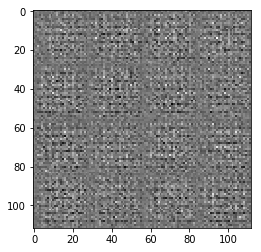

Epoch 1/2... Discriminator Loss: 1.5702... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 1.3621
Epoch 1/2... Discriminator Loss: 1.6750... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 1.0928
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.8712
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 2.0575... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 1.0915


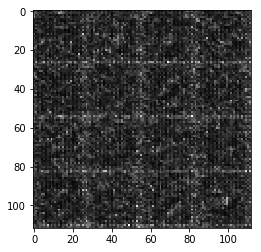

Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 1.7650... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.7387... Generator Loss: 1.4316
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.9056


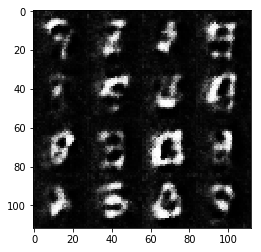

Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 1.2003
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 0.6116


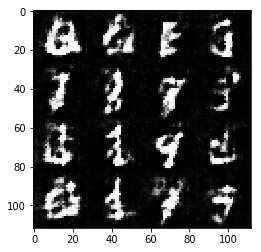

Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.9235
Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 1.4538... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.9375


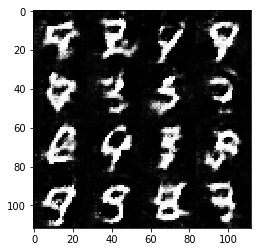

Epoch 1/2... Discriminator Loss: 1.5881... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.6763


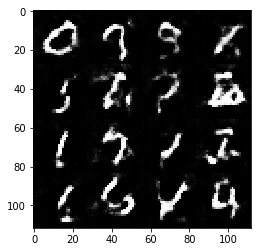

Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.6004... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 1.0592


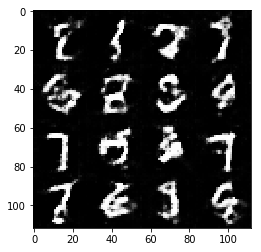

Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.5457... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.9452


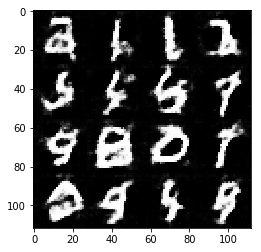

Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.7707


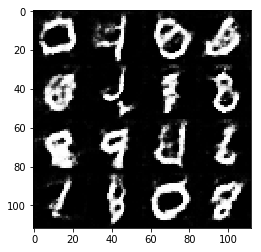

Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.8591


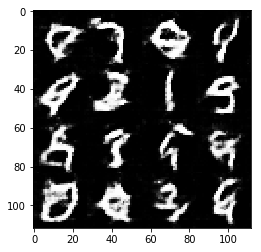

Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.8238
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 0.8723


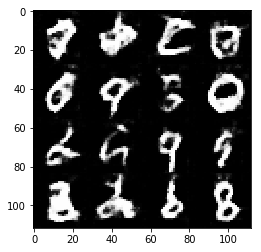

Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.8204


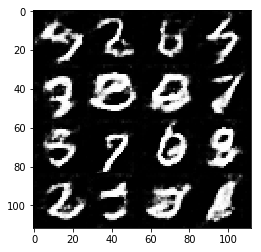

Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.8991


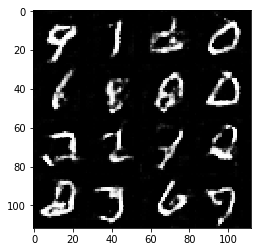

Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.8895


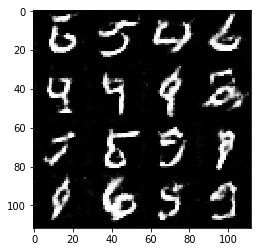

Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.4679... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.8416


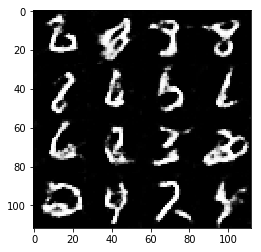

Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.8040
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.8611


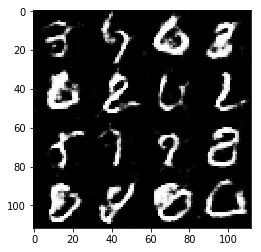

Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.8663


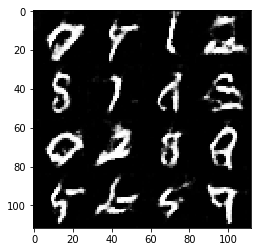

Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.7978


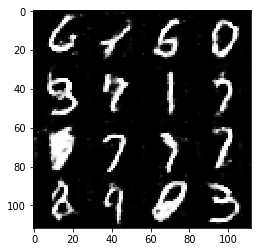

Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.4331... Generator Loss: 0.6901


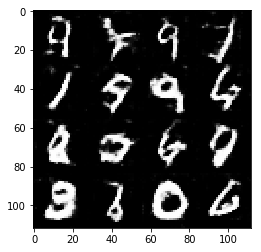

Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8334


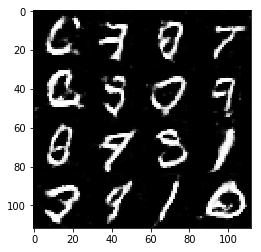

Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.6479


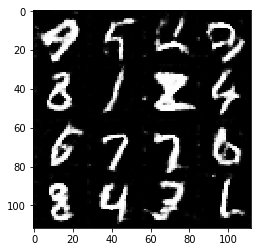

Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.8372
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.8175


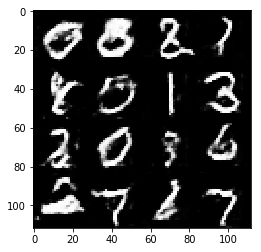

Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.7179


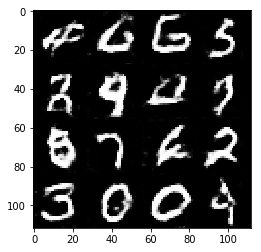

Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7897


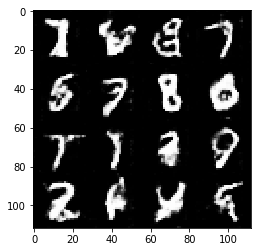

Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7731


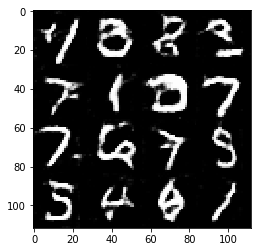

Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.4910... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.8203


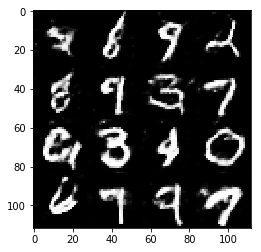

Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.7831


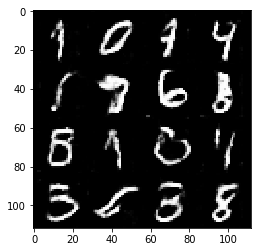

Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7749
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.7575


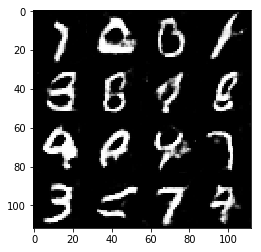

Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.8111


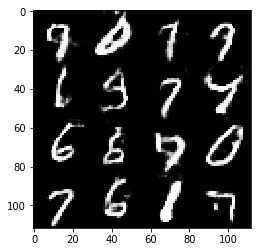

Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.7494


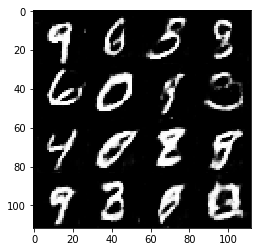

Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.7661


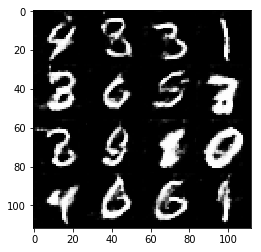

Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.8238


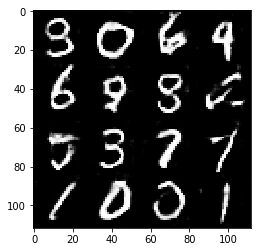

Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.8147


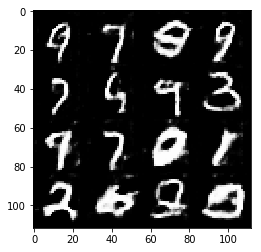

Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.4435... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.7745


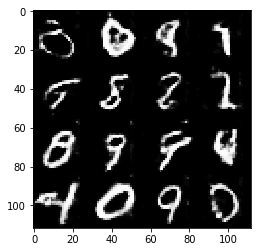

Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.9168


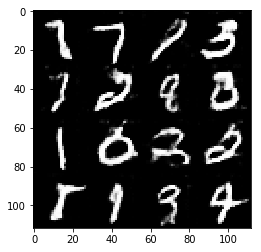

Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.8140


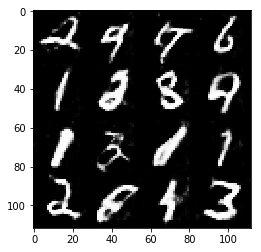

Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.8250


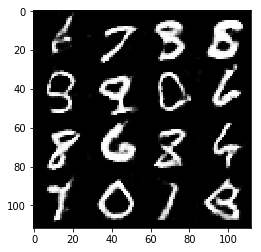

Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.8491


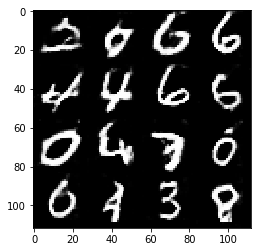

Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.7710


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7604... Generator Loss: 0.3067


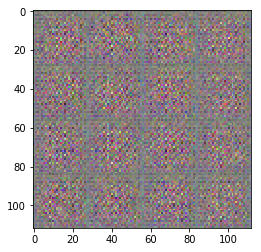

Epoch 1/1... Discriminator Loss: 1.8761... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.8627... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.9732... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 2.1401... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 2.1849... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.8688... Generator Loss: 1.0680


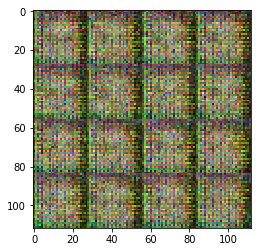

Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.7800


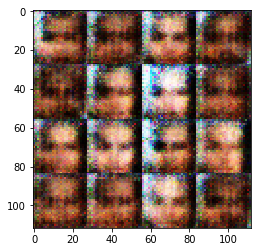

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.9248


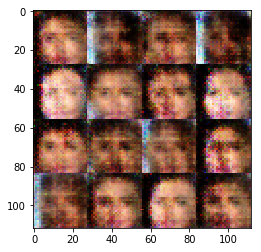

Epoch 1/1... Discriminator Loss: 1.8188... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.8263


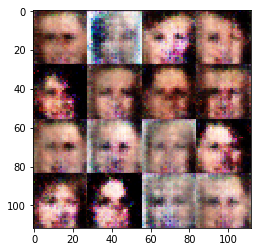

Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.8538


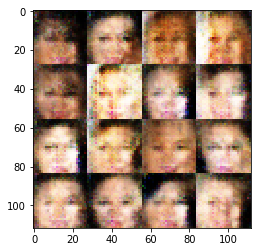

Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.8131


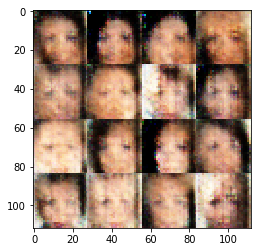

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8467


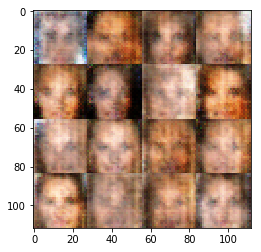

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7615


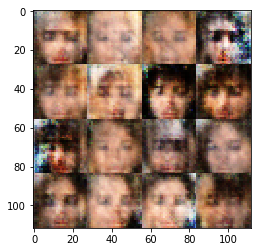

Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.8001


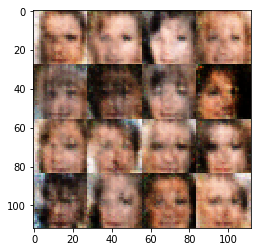

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7902


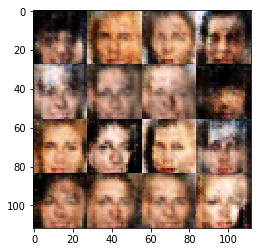

Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7417


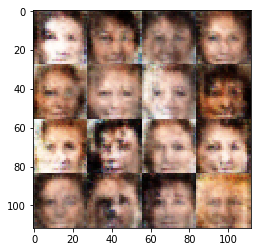

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7455


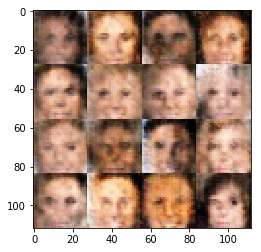

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7759


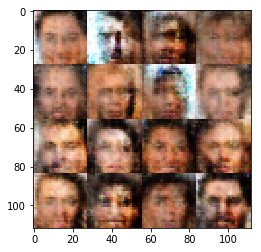

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7205


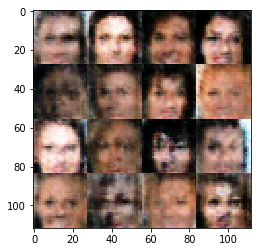

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7804


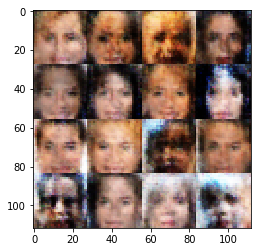

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7389


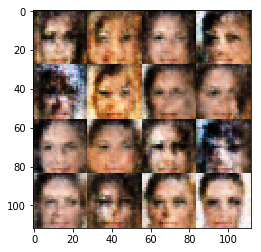

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8090


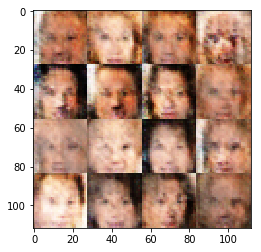

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7492


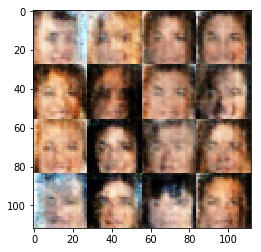

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7851


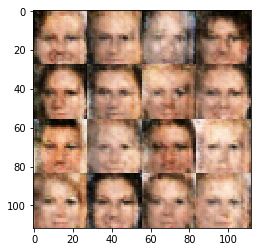

Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8135


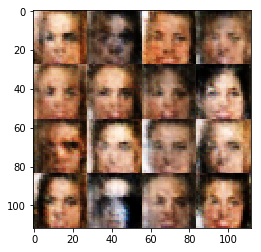

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7843


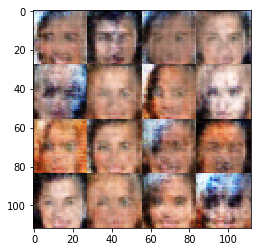

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7635


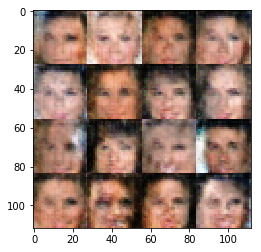

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7628


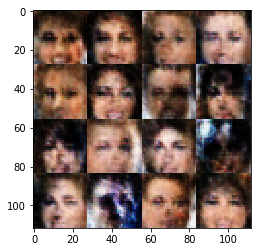

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7264


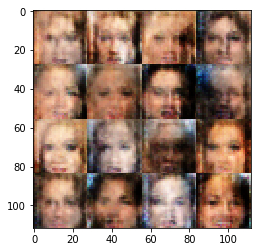

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7656


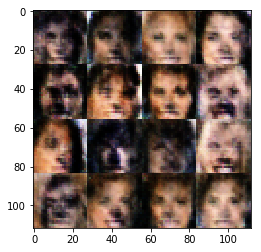

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8001


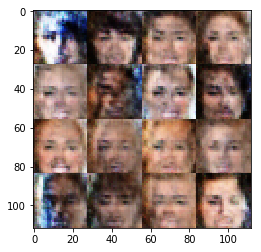

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8065


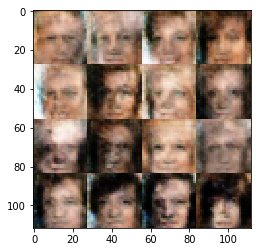

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8047


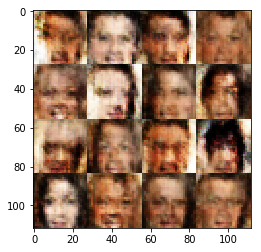

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8072


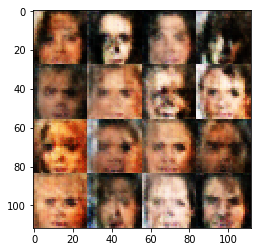

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.